In [12]:
# Cell 1: Import required libraries and download NLTK resources
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [13]:
# Download all required NLTK resources
print("Downloading required NLTK resources...")
resources = ['punkt', 'stopwords', 'wordnet', 'vader_lexicon', 'averaged_perceptron_tagger']
for resource in resources:
    try:
        nltk.download(resource, quiet=True)
        print(f"✓ Successfully downloaded {resource}")
    except Exception as e:
        print(f"✗ Error downloading {resource}: {str(e)}")

✓ Successfully downloaded punkt
✓ Successfully downloaded stopwords
✓ Successfully downloaded wordnet
✓ Successfully downloaded vader_lexicon
✓ Successfully downloaded averaged_perceptron_tagger


In [14]:
# Cell 2: Load and examine the data
# Read the CSV file
df = pd.read_csv("C:\\Users\\Bishwash Chhetri\\Desktop\\ineubytes\\air_india_reviews.csv\\air_india_reviews.csv")

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
print(df.info())
print("\nSample Reviews:")
print("-" * 50)
print(df[['rating', 'title', 'text']].head())


Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4840 entries, 0 to 4839
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   published_date  4840 non-null   object
 1   rating          4840 non-null   int64 
 2   type            4840 non-null   object
 3   helpful_votes   4840 non-null   int64 
 4   title           4840 non-null   object
 5   text            4840 non-null   object
dtypes: int64(2), object(4)
memory usage: 227.0+ KB
None

Sample Reviews:
--------------------------------------------------
   rating                                        title  \
0       1              BAD SERVICE AND BAD HOSPITALITY   
1       1         AI 188 and AI 187 flight nightmare !   
2       1  worst airline to travel dont waste ur money   
3       3                         Good, Can be Better!   
4       1                   Poor airlines and services   

   

In [15]:
# Cell 3: Define text preprocessing functions
def preprocess_text(text, lemmatizer, stop_words):
    """Clean and preprocess the text data"""
    if not isinstance(text, str):
        return ""
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
             if token not in stop_words]
    
    return ' '.join(tokens)

In [17]:
# Cell 4: Initialize NLP tools
try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    sia = SentimentIntensityAnalyzer()
    print("✓ Successfully initialized NLP tools")
except Exception as e:
    print(f"✗ Error initializing NLP tools: {str(e)}")
    raise

✓ Successfully initialized NLP tools


In [18]:
# Cell 5: Define sentiment analysis functions
def get_vader_sentiment(text):
    """Get sentiment scores using VADER"""
    scores = sia.polarity_scores(text)
    
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def get_rating_sentiment(rating):
    """Convert numerical rating to sentiment category"""
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

In [20]:
# Cell 6: Preprocess the reviews
print("Preprocessing reviews...")
# Apply text preprocessing
df['processed_text'] = df['text'].apply(lambda x: preprocess_text(x, lemmatizer, stop_words))
print("✓ Text preprocessing complete")

# Get sentiments
print("Analyzing sentiments...")
df['text_sentiment'] = df['text'].apply(get_vader_sentiment)
df['rating_sentiment'] = df['rating'].apply(get_rating_sentiment)
print("✓ Sentiment analysis complete")

Preprocessing reviews...
✓ Text preprocessing complete
Analyzing sentiments...
✓ Sentiment analysis complete


In [21]:
# Cell 7: Combine sentiments
# Combine both sentiment signals
df['final_sentiment'] = df.apply(lambda row: 
    'positive' if (row['rating_sentiment'] == 'positive' or 
                  (row['rating_sentiment'] == 'neutral' and row['text_sentiment'] == 'positive'))
    else 'negative' if (row['rating_sentiment'] == 'negative' or 
                       (row['rating_sentiment'] == 'neutral' and row['text_sentiment'] == 'negative'))
    else 'neutral', axis=1)

In [22]:
# Cell 8: Analyze sentiment distribution
# Calculate sentiment statistics
sentiment_counts = df['final_sentiment'].value_counts()
total_reviews = len(df)

print("\nSentiment Distribution:")
print("-" * 50)
for sentiment, count in sentiment_counts.items():
    percentage = (count/total_reviews) * 100
    print(f"{sentiment.capitalize()}: {count} reviews ({percentage:.1f}%)")


Sentiment Distribution:
--------------------------------------------------
Negative: 2800 reviews (57.9%)
Positive: 2017 reviews (41.7%)
Neutral: 23 reviews (0.5%)


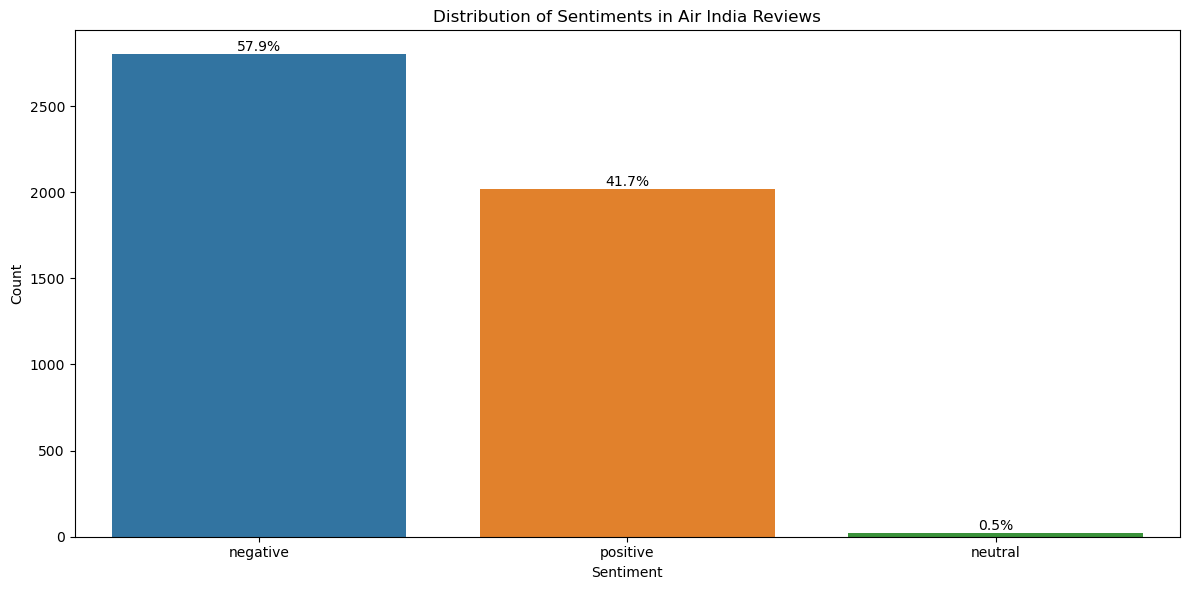

In [23]:
# Cell 9: Visualize sentiment distribution
plt.figure(figsize=(12, 6))

# Plot sentiment distribution
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiments in Air India Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add percentage labels
for i, count in enumerate(sentiment_counts):
    percentage = count/total_reviews * 100
    plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [24]:
# Cell 10: Analyze top terms by sentiment
def get_top_terms(df, sentiment, n=10):
    """Get top terms associated with each sentiment"""
    sentiment_texts = ' '.join(df[df['final_sentiment'] == sentiment]['processed_text'])
    vectorizer = TfidfVectorizer(max_features=n)
    tfidf_matrix = vectorizer.fit_transform([sentiment_texts])
    
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    
    return sorted(zip(feature_names, tfidf_scores), 
                 key=lambda x: x[1], reverse=True)

In [25]:
# Cell 11: Print top terms for each sentiment
print("\nTop Terms by Sentiment:")
print("-" * 50)
for sentiment in ['positive', 'negative', 'neutral']:
    print(f"\nTop 10 terms in {sentiment} reviews:")
    top_terms = get_top_terms(df, sentiment, n=10)
    for term, score in top_terms:
        print(f"- {term}: {score:.3f}")


Top Terms by Sentiment:
--------------------------------------------------

Top 10 terms in positive reviews:
- flight: 0.629
- india: 0.365
- air: 0.358
- good: 0.324
- food: 0.249
- time: 0.241
- service: 0.207
- airline: 0.173
- seat: 0.162
- staff: 0.140

Top 10 terms in negative reviews:
- flight: 0.638
- india: 0.410
- air: 0.403
- airline: 0.223
- hour: 0.208
- seat: 0.205
- time: 0.201
- service: 0.196
- staff: 0.163
- one: 0.144

Top 10 terms in neutral reviews:
- flight: 0.690
- india: 0.322
- food: 0.299
- air: 0.253
- experience: 0.230
- staff: 0.230
- good: 0.207
- one: 0.207
- service: 0.207
- time: 0.184


In [26]:
# Cell 12: Save results (optional)
# Save processed data to CSV
df.to_csv('air_india_reviews_with_sentiment.csv', index=False)

In [30]:
# Cell 13: Function to display a random review with simple sentiment
def show_random_review():
    """Display a random review with its sentiment"""
    review = df.sample(n=1).iloc[0]
    print(f"Review: {review['text']}")
    print(f"Sentiment: {review['final_sentiment']}")

In [33]:
show_random_review()

Review: Horrible cabin staff service, 
Don't know how to talk & behave to passenger.
Showing his anger, Not answer properly if ask anything.
Sentiment: negative
